In [1]:
# https://www.kaggle.com/datasets/arjunbhasin2013/ccdata?resource=download

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# https://www.kaggle.com/datasets/arjunbhasin2013/ccdata?resource=download

df = pd.read_csv('CC GENERAL.csv')

In [4]:
df.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

In [5]:
df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].median(), inplace=True)
df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median(), inplace=True)

In [6]:
df = df.drop(columns=['CUST_ID'])

In [7]:
df['PURCHASES_PER_MONTH'] = df['PURCHASES'] / df['TENURE']
df['CASH_ADVANCE_PER_MONTH'] = df['CASH_ADVANCE'] / df['TENURE']

df['ONEOFF_RATIO'] = np.where(df['PURCHASES'] == 0, np.nan, df['ONEOFF_PURCHASES'] / df['PURCHASES'])
df['INSTALLMENT_RATIO'] = np.where(df['PURCHASES'] == 0, np.nan, df['INSTALLMENTS_PURCHASES'] / df['PURCHASES'])
df['PAYMENT_RATIO'] = np.where(df['PURCHASES'] == 0, np.nan, df['PAYMENTS'] / df['PURCHASES'])
df['CASHADV_CREDITLIMIT_RATIO'] = np.where(df['CREDIT_LIMIT'] == 0, np.nan, df['CASH_ADVANCE'] / df['CREDIT_LIMIT'])

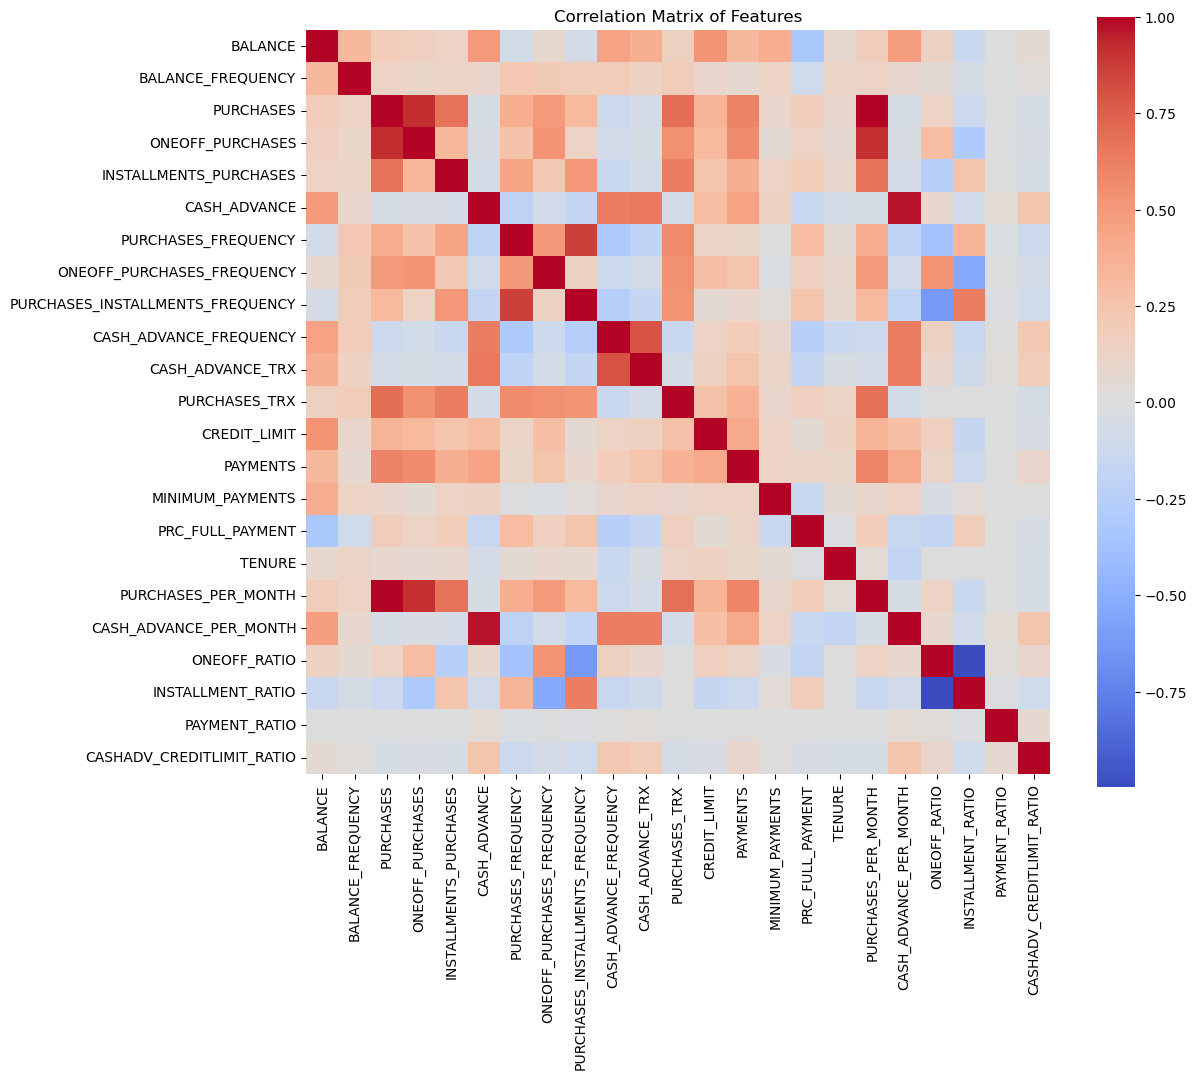

In [8]:
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt='.2f', square=True, cbar=True)
plt.title('Correlation Matrix of Features')
plt.show()

In [9]:
df.fillna(0, inplace=True)

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

In [11]:
inertia = []
sil_scores = []
K_range = range(2, 11)

In [12]:
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

### Elbow Method

The Elbow plot shows inertia (within-cluster sum of squares) decreasing steadily as the number of clusters increases. There is no sharp "elbow," but the curve starts flattening between 4 and 6 clusters. 

Text(0, 0.5, 'Inertia')

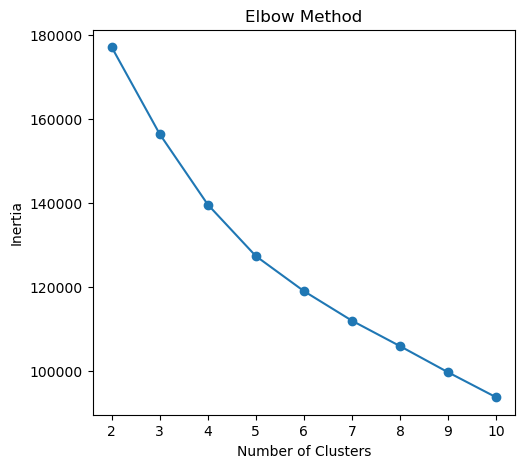

In [13]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

### Silhouette Score

The silhouette score peaks at 6 clusters (~0.21). Although this score is low, indicating overlapping clusters, it still suggests weak but present clustering structure.

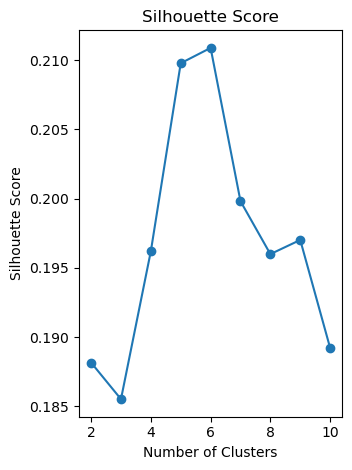

In [14]:
plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

In [15]:
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster_KMeans'] = kmeans_final.fit_predict(X_scaled)


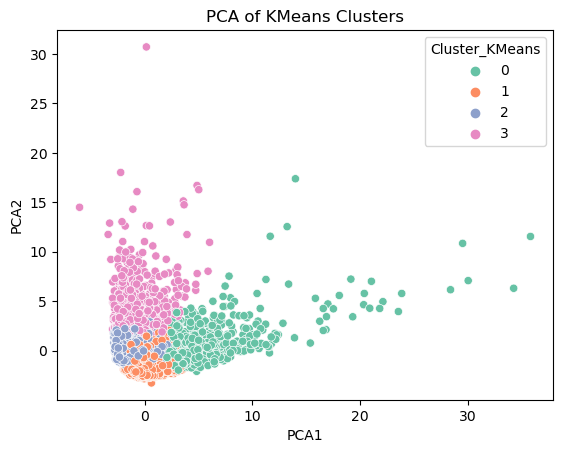

       BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES   
0  2488.364515           0.981360  5079.146265       3426.471621  \
1   708.692841           0.854510   735.480282        152.333814   
2  1233.683524           0.849859   390.571675        359.420292   
3  4576.198974           0.955512   486.332689        308.830220   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY   
0             1653.331818    453.394030             0.943015  \
1              583.627406    189.853687             0.756125   
2               31.278517    638.282596             0.216980   
3              177.566536   5088.281903             0.275057   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY   
0                    0.741189                          0.718519  \
1                    0.091107                          0.700725   
2                    0.184993                          0.048053   
3                    0.135768                          0.175867   

  

In [16]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

# Plot PCA of KMeans clusters
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster_KMeans', palette='Set2')
plt.title('PCA of KMeans Clusters')
plt.show()

# Print cluster centroids in original scale
centroids_scaled = kmeans_final.cluster_centers_
centroids_orig = scaler.inverse_transform(centroids_scaled)
centroids_df = pd.DataFrame(centroids_orig, columns=df.columns[:-3])
print(centroids_df)

## KMeans Cluster Profiles and Business Insights

### Cluster 0: Active High Spenders
- **Profile:** High balance (2500), large purchases (5000), mainly one-off purchases (66%). High purchase frequency (94%), pays off purchases (payment ratio ~1).
- **Business Insight:** These are valuable, engaged customers. They could be targeted with premium rewards programs, loyalty incentives, and upsell offers for higher-tier products. 

### Cluster 1: Moderate Spenders, Reliable Payers
- **Profile:** Low balance (700), smaller purchases (735) dominated by installments (88%). Pays more than they spend (payment ratio ~2.8), decent full payment rate (25%).
- **Business Insight:** Low risk. Good candidates for increased credit limits, cross-sell of installment plan offers, or balance transfer promotions.

### Cluster 2: Occasional Spenders, Cash Advance Users
- **Profile:** Moderate balance (1200), low purchases (390), high reliance on cash advances (~640). High payment ratio (9+), low full payment rate (6%).
- **Business Insight:** This group shows mixed signals. They make infrequent purchases but use cash advances regularly. Could be candidates for personal loan offers or financial education programs to reduce cash advance dependency.

### Cluster 3: Heavy Cash Advance Dependent
- **Profile:** Very high balance (4500), minimal purchases (486), massive cash advance usage (~5000). Extremely high payment ratio (500+), cash advance near credit limit (90%).
- **Business Insight:** High-risk group. Likely using the card as a line of credit rather than for purchases. These customers should be monitored for credit risk. Banks could offer alternatives like structured loans or credit counseling.

In [17]:
centroids_scaled = kmeans_final.cluster_centers_
centroids_orig = scaler.inverse_transform(centroids_scaled)
centroids_df = pd.DataFrame(centroids_orig, columns=df.columns[:-3])  # exclude cluster/PCA cols
print(centroids_df)

       BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES   
0  2488.364515           0.981360  5079.146265       3426.471621  \
1   708.692841           0.854510   735.480282        152.333814   
2  1233.683524           0.849859   390.571675        359.420292   
3  4576.198974           0.955512   486.332689        308.830220   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY   
0             1653.331818    453.394030             0.943015  \
1              583.627406    189.853687             0.756125   
2               31.278517    638.282596             0.216980   
3              177.566536   5088.281903             0.275057   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY   
0                    0.741189                          0.718519  \
1                    0.091107                          0.700725   
2                    0.184993                          0.048053   
3                    0.135768                          0.175867   

  

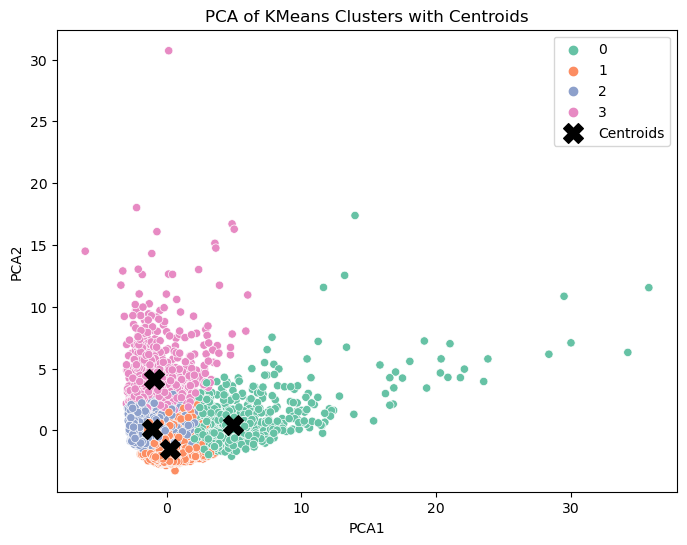

In [26]:
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster_KMeans', palette='Set2', legend='full')
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], s=200, c='black', marker='X', label='Centroids')
plt.title('PCA of KMeans Clusters with Centroids')
plt.legend()
plt.show()

## Other experiments

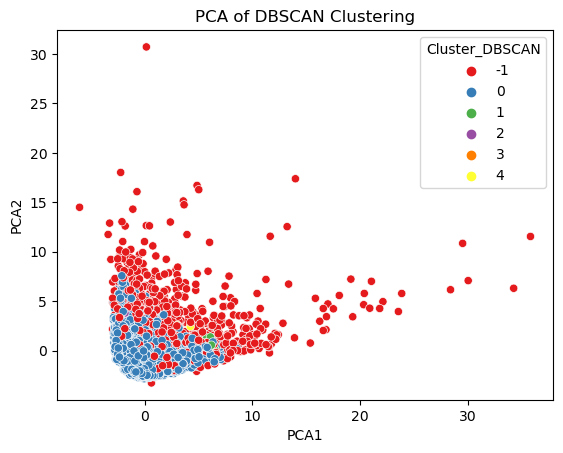

DBSCAN noise points: 830 / 8950


In [18]:
# Fit DBSCAN
dbscan = DBSCAN(eps=2, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Add to dataframe
df['Cluster_DBSCAN'] = dbscan_labels

# Visualize
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster_DBSCAN', palette='Set1', legend='full')
plt.title('PCA of DBSCAN Clustering')
plt.show()

# Check how many noise points (-1)
print(f"DBSCAN noise points: {(dbscan_labels == -1).sum()} / {len(dbscan_labels)}")

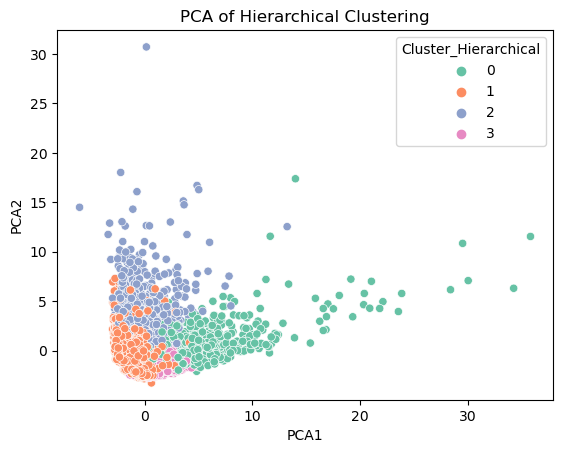

In [19]:
hier = AgglomerativeClustering(n_clusters=4)
df['Cluster_Hierarchical'] = hier.fit_predict(X_scaled)

# Visualize
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster_Hierarchical', palette='Set2', legend='full')
plt.title('PCA of Hierarchical Clustering')
plt.show()

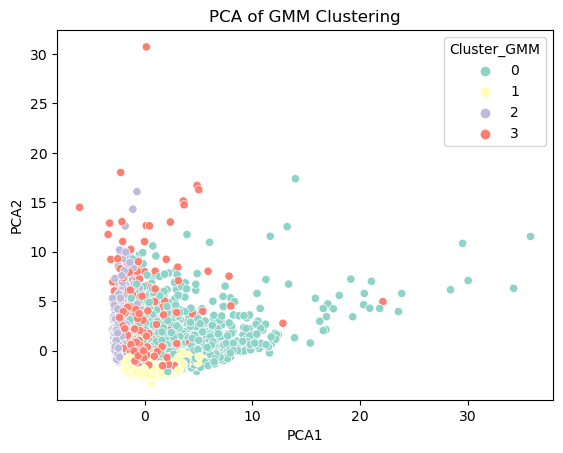

GMM AIC: -444312.66
GMM BIC: -435800.47


In [20]:
# Fit GMM
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

# Add to dataframe
df['Cluster_GMM'] = gmm_labels

# Visualize
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster_GMM', palette='Set3', legend='full')
plt.title('PCA of GMM Clustering')
plt.show()

# Optional: Show AIC/BIC for model selection
print(f"GMM AIC: {gmm.aic(X_scaled):.2f}")
print(f"GMM BIC: {gmm.bic(X_scaled):.2f}")

In [21]:
print(df['Cluster_KMeans'].value_counts().sort_index())
print(df['Cluster_DBSCAN'].value_counts().sort_index())
print(df['Cluster_Hierarchical'].value_counts().sort_index())
print(df['Cluster_GMM'].value_counts().sort_index())

Cluster_KMeans
0     910
1    3198
2    3797
3    1045
Name: count, dtype: int64
Cluster_DBSCAN
-1     830
 0    8104
 1       5
 2       3
 3       3
 4       5
Name: count, dtype: int64
Cluster_Hierarchical
0    1583
1    3772
2    1321
3    2274
Name: count, dtype: int64
Cluster_GMM
0    2357
1    3777
2    2231
3     585
Name: count, dtype: int64
